# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d_sim import *
from MaaSSim.d2d_demand import *
from MaaSSim.d2d_supply import *
from MaaSSim.shared import prep_shared_rides
from MaaSSim.decisions import dummy_False

In [3]:
import pandas as pd
import zipfile
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

In [4]:
# Load config
params = get_config('../../data/config/ams.json')  # load configuration

In [5]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 1

# Main experimental settings
params.nP = 5000 # travellers
params.nV = 100 # drivers
params.nD = 50 # days
params.simTime = 8 # hours

In [6]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 10 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 0.05 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 10 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

params.evol.travellers.inform.prob_start = 0.1
params.evol.travellers.inform.beta = 0.2
params.evol.travellers.inform.start_wait = 0
params.evol.travellers.reject_penalty = 30 * 60 # seconds
params.evol.travellers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.63 #euro/km
params.platforms.min_fare = 6 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Properties alternative modes
params.alt_modes.pt.base_fare = 0.99 # euro
params.alt_modes.pt.km_fare = 0.174 # euro/km
params.alt_modes.pt.access_time = 10 * 60  #s, includes egress (not waiting)
params.alt_modes.pt.wait_time = 7.5 * 60 #s
params.alt_modes.car.km_cost = 0.5 # euro/km
params.alt_modes.car.park_cost = 5 # euro
params.alt_modes.car.access_time = 10 * 60 # s
params.speeds.bike = 4 # m/s
params.speeds.pt = 0.5 * params.speeds.ride # considering stops

# Mode choice parameters
params.mode_choice.ASC_car = 0 # util, rel to bike
params.mode_choice.ASC_rs = 0
params.mode_choice.ASC_pt = 0
params.mode_choice.beta_access = -0.0475 / 60 # util/s
params.mode_choice.beta_cost = -0.1515 # util/euro
params.mode_choice.beta_time_bike = -0.0693 / 60 #util/s
params.mode_choice.beta_time_moto = -0.0106 / 60
params.mode_choice.beta_wait_rs = -0.0398 / 60 # -0.0156
params.mode_choice.beta_wait_pt = -0.0398 / 60

# Demand settings
params.demand_structure.origins_dispertion = -0.0003
params.demand_structure.destinations_dispertion = -0.0003
params.dist_threshold_min = 2000 # min dist
params.dist_threshold = 100000 # max dist

# Start time
params.t0 = pd.Timestamp.now()

In [7]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
inData.passengers['informed'] = np.random.rand(params.nP) < params.evol.travellers.inform.prob_start
inData.passengers['expected_wait'] = params.evol.travellers.inform.start_wait
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [8]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    kpi_pax = d2d_kpi_pax,
                    f_driver_out = D2D_driver_out,
                    f_trav_out = d2d_no_request,
                    f_trav_mode = dummy_False,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf_driver = wom_driver(inData, params = params)
    inData.vehicles.informed = res_inf_driver
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos
    res_inf_trav = wom_trav(inData, d2d.travs[day], params = params)
    inData.passengers.informed = res_inf_trav.informed
    inData.passengers.expected_wait = res_inf_trav.perc_wait

12-04-21 15:53:49-WARNING-Setting up 8h simulation at 2021-04-12 11:53:07 for 100 vehicles and 5000 passengers in Amsterdam, Netherlands
12-04-21 15:54:19-WARNING-day 0: simulation time 21.6 s
12-04-21 15:54:24-WARNING-assertion tests for simulation results - passed
12-04-21 15:54:53-WARNING-day 1: simulation time 21.0 s
12-04-21 15:54:57-WARNING-assertion tests for simulation results - passed
12-04-21 15:55:28-WARNING-day 2: simulation time 23.4 s
12-04-21 15:55:32-WARNING-assertion tests for simulation results - passed
12-04-21 15:56:05-WARNING-day 3: simulation time 24.1 s
12-04-21 15:56:09-WARNING-assertion tests for simulation results - passed
12-04-21 15:56:43-WARNING-day 4: simulation time 25.0 s
12-04-21 15:56:48-WARNING-assertion tests for simulation results - passed
12-04-21 15:57:26-WARNING-day 5: simulation time 29.7 s
12-04-21 15:57:30-WARNING-assertion tests for simulation results - passed
12-04-21 15:58:05-WARNING-day 6: simulation time 26.6 s
12-04-21 15:58:09-WARNING-a

In [31]:
evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

In [32]:
with zipfile.ZipFile('evol.zip', 'w') as csv_zip:
    csv_zip.writestr("evol_agg_supply.csv", evol_agg.supply.to_csv())
    csv_zip.writestr("evol_agg_demand.csv", evol_agg.demand.to_csv())

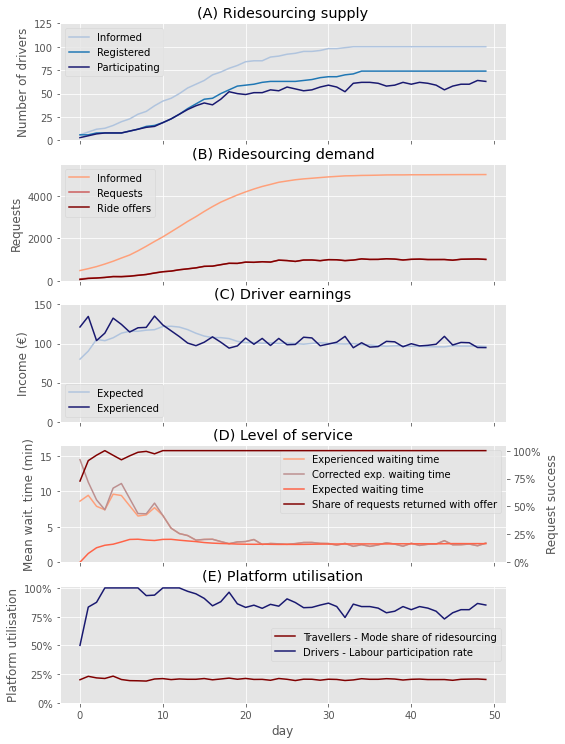

In [44]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (8,12.5), sharex = True)
evol_agg.supply[['inform','regist','particip']].plot(ax = axes[0], color=['lightsteelblue','tab:blue','midnightblue'])
axes[0].set_title('(A) Ridesourcing supply')
axes[0].legend(['Informed','Registered','Participating'])
axes[0].set_ylim([0,params.nV + 25])
axes[0].set_ylabel('Number of drivers')
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[2], color=['lightsteelblue','midnightblue'])
axes[2].set_title('(C) Driver earnings')
axes[2].legend(['Expected','Experienced'])
axes[2].set_ylim([0,math.ceil(max(evol_agg.supply.mean_perc_inc.max(),evol_agg.supply.mean_exp_inc.max())/50)*50])
axes[2].set_ylabel('Income (\u20ac)')

evol_agg.demand[['inform','requests','gets_offer']].plot(ax = axes[1], color=['lightsalmon','indianred','maroon'])
axes[1].set_title('(B) Ridesourcing demand')
axes[1].legend(['Informed','Requests','Ride offers'])
axes[1].set_ylim([0,params.nP * 1.1])
axes[1].set_ylabel('Requests')

ax_sec = axes[3].twinx()
evol_agg.demand['proport_match'] = evol_agg.demand.gets_offer / evol_agg.demand.requests * 100
evol_agg.demand['mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Experienced waiting time', color ='lightsalmon')
evol_agg.demand['corr_mean_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Corrected exp. waiting time', color ='rosybrown')
evol_agg.demand['perc_wait'].apply(lambda x: 1/60 * x).plot(ax = axes[3], label='Expected waiting time', color ='tomato')
evol_agg.demand['proport_match'].plot(ax = ax_sec, color = 'maroon', label='Share of requests returned with offer')
lines_1, labels_1 = axes[3].get_legend_handles_labels()
lines_2, labels_2 = ax_sec.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axes[3].legend(lines, labels, loc=0)
axes[3].set_title('(D) Level of service')
axes[3].set_ylabel('Mean wait. time (min)')
ax_sec.set_ylabel('Request success')
ax_sec.yaxis.set_major_formatter(mtick.PercentFormatter())
max_val = max(evol_agg.demand.mean_wait.max(),evol_agg.demand.corr_mean_wait.max(),evol_agg.demand.perc_wait.max())
axes[3].set_ylim([0,math.ceil((1/60)*max_val/2)*2+0.5])
ax_sec.set_ylim([0,100+5])
ax_sec.grid(None)

proport_rs = evol_agg.demand.requests / evol_agg.demand.inform * 100 
proport_rs.plot(ax = axes[4], label = 'Travellers - Mode share of ridesourcing', color='maroon')
axes[4].set_title('(E) Platform utilisation')
axes[4].set_ylim([0,100+2])
axes[4].set_ylabel('Platform utilisation')

axes[4].yaxis.set_major_formatter(mtick.PercentFormatter())

proport_work = evol_agg.supply.particip / evol_agg.supply.regist * 100
proport_work.plot(ax = axes[4], label = 'Drivers - Labour participation rate', color ='midnightblue')
lines, labels = axes[4].get_legend_handles_labels()
axes[4].legend(labels)

plt.savefig('d2d-evo.png')

In [34]:
evol_agg.supply

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,6,6,3,80.000000,121.168167
1,9,6,5,90.292042,134.703880
2,12,8,7,105.269031,103.761686
3,13,8,8,103.634043,113.293287
4,16,8,8,107.329090,132.490178
5,20,8,8,113.274087,124.496084
6,23,10,10,115.743991,114.707107
7,28,12,12,115.677216,120.161842
8,31,15,14,117.104333,120.658075


In [35]:
evol_agg.demand

,inform,requests,gets_offer,accepts_offer,mean_wait,corr_mean_wait,perc_wait,proport_match
day,,,,,,,,
0,493,99,72,72,516.236111,866.353535,0.000000,72.727273
1,581,134,122,122,565.532787,676.082090,73.811532,91.044776
2,678,147,141,141,472.609929,526.789116,122.322026,95.918367
3,798,169,169,169,443.112426,443.112426,143.270886,100.000000
4,930,216,207,207,574.956522,626.000000,152.143280,95.833333
5,1080,219,201,201,563.636816,665.255708,171.554969,91.780822
6,1223,236,225,225,476.462222,538.152542,192.402289,95.338983
7,1419,272,268,268,390.406716,411.136029,194.254266,98.529412
8,1633,309,307,307,400.087948,409.148867,187.300886,99.352751
